In [1]:
import pandas as pd

In [2]:
# read the csv file
streams = pd.read_csv('streams.csv', index_col=0)
streams.head()

,date,country,region,gender,n_of_streams
0,2021-10-19,US,539,NaN,23
1,2021-10-20,SE,SE-AB,male,110
2,2021-10-26,FR,FR-67,male,3
3,2021-11-28,EC,EC-F,female,3
4,2021-10-17,GR,GR-54,NaN,1


In [3]:
# pandas shape() function allows you to know number of rows and columns in the dataset
streams.shape

(233741, 5)

In [4]:
# using the min, max functions you may display the date range of dataset
min_date = streams["date"].min()
max_date = streams["date"].max()

print(f"Information is available for dates from {min_date} to {max_date}")


Information is available for dates from 2021-10-09 to 2021-12-11


In [5]:
# you may use nunique() function to display the number of unique values in the column

num_countries = streams['country'].nunique(dropna=True)

num_regions = streams['region'].nunique(dropna=True)

num_genders = streams['gender'].nunique(dropna=True)

print(f"There are:\n"
      f" {num_countries} unique countries \n"
      f" {num_regions} unique regions and\n"
      f" {num_genders} genders in dataset")

There are:
 176 unique countries 
 2359 unique regions and
 3 genders in dataset


In [6]:
# unlike the nunique() function which display the count of unique values in the column, unique() function displays the values
streams["gender"].dropna().unique()

array(['male', 'female', 'all'], dtype=object)

In [7]:
# isnull() function finds the rown where the given value is missing

missing_countries = streams['country'].isnull().sum()

missing_region = streams['region'].isnull().sum()

missing_gender = streams['gender'].isnull().sum()

missing_streams = streams['n_of_streams'].isnull().sum()

print(f"The dataset has:\n"
    f" {missing_countries} missing values in the 'country' column.\n"
    f" {missing_region} missing values in the 'region' column.\n"
    f" {missing_streams} missing values in the 'n_of_streams' column."
)

The dataset has:
 34 missing values in the 'country' column.
 2402 missing values in the 'region' column.
 0 missing values in the 'n_of_streams' column.


In [8]:
# count of streams per country
s = pd.DataFrame(streams.groupby('country')["n_of_streams"].sum())

# count of egions per country
s['Total_regions'] = streams.groupby('country')['region'].nunique()

# average number of streams per county
s['avg_streams'] = streams.groupby('country')["n_of_streams"].mean()

# sandard deviation of streams
s['st.dev'] = round(s['n_of_streams'].std(),2)

# percentage of streams per country
s['percent'] = (s['n_of_streams'] / s['n_of_streams'].sum()) * 100

# display first few rows of dataframe
s.head()


,n_of_streams,Total_regions,avg_streams,st.dev,percent
country,,,,,
AD,645,7,2.320144,346913.96,0.005185
AE,3409,7,4.998534,346913.96,0.027404
AG,32,3,1.333333,346913.96,0.000257
AL,270,7,1.607143,346913.96,0.002170
AM,32,3,1.000000,346913.96,0.000257


In [9]:
# count of streams per gender excluding the rows with summed values (gender == all)
s1=pd.DataFrame(streams[streams['gender'] != 'all']
                .groupby('gender')['n_of_streams']
                .sum())

# percent of streams per gender
s1['percent'] = round(((s1['n_of_streams'] / s1['n_of_streams'].sum()) * 100),2)

# count of regions per gender
s1['Total_regions'] = streams.groupby('gender')['region'].nunique()

# display first few rows of dataframe
s1.head()

,n_of_streams,percent,Total_regions
gender,,,
female,2269890,38.31,1997
male,3655698,61.69,2168


######    

In [10]:
# filtering data to exclude duplications (gender == all)
streams_filtered = streams[streams['gender'] != 'all']

# define function to compute the outliers
def compute_outliers(group):
    # Calculate Q1, Q3, and IQR
    Q1 = group['n_of_streams'].quantile(0.25)
    Q3 = group['n_of_streams'].quantile(0.75)
    IQR = Q3 - Q1

    # Determine outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Assign a boolean variable indicating whether the row is an outlier
    group["outlier"] = (group['n_of_streams'] < lower_bound) | (group['n_of_streams'] > upper_bound)
    
    return group
  
# Group by 'country', 'region', and 'gender' and apply a function
streams_outliers = streams_filtered.groupby(['country', 'region', 'gender']).apply(compute_outliers)

streams_outliers.reset_index(drop=True, inplace=True)

# Display the first few rows to verify
print(streams_outliers.head())


C:\Users\ANNA M\AppData\Local\Temp\ipykernel_5320\1214873704.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  streams_outliers = streams_filtered.groupby(['country', 'region', 'gender']).apply(compute_outliers)


         date country  region  gender  n_of_streams  outlier
0  2021-10-20      SE   SE-AB    male           110    False
1  2021-10-26      FR   FR-67    male             3    False
2  2021-11-28      EC    EC-F  female             3    False
3  2021-11-13      HK  HK-HCW    male            24    False
4  2021-10-09      US     609    male            28    False


In [11]:
# `.copy()` method ensures a clean copy of a dataset
spikes = streams_filtered.copy()  

# computing moving averages
spikes.loc[:, 'MA_3'] = (
    spikes.groupby(['country', 'region', 'gender'])['n_of_streams']
    .transform(lambda x: x.shift(1).rolling(3).mean())
)

spikes.loc[:, 'MA_10'] = (
    spikes.groupby(['country', 'region', 'gender'])['n_of_streams']
    .transform(lambda x: x.shift(1).rolling(10).mean())
)

# adding a column with boolean value that shows the spikes
spikes.loc[:, 'spike'] = spikes['MA_3'] > (spikes['MA_10'] * 1.1)

print(spikes)

              date country region  gender  n_of_streams       MA_3  MA_10  \
0       2021-10-19      US    539     NaN            23        NaN    NaN   
1       2021-10-20      SE  SE-AB    male           110        NaN    NaN   
2       2021-10-26      FR  FR-67    male             3        NaN    NaN   
3       2021-11-28      EC   EC-F  female             3        NaN    NaN   
4       2021-10-17      GR  GR-54     NaN             1        NaN    NaN   
...            ...     ...    ...     ...           ...        ...    ...   
233736  2021-11-10      US    518     NaN             2        NaN    NaN   
233737  2021-10-21      US    686    male             4   5.333333    8.0   
233738  2021-11-24      PL  PL-22    male             9   5.333333    9.2   
233739  2021-11-21      SK  SK-ZI  female             4   1.333333    2.4   
233740  2021-12-05      BR  BR-RS    male            16  11.333333   17.0   

        spike  
0       False  
1       False  
2       False  
3       Fal

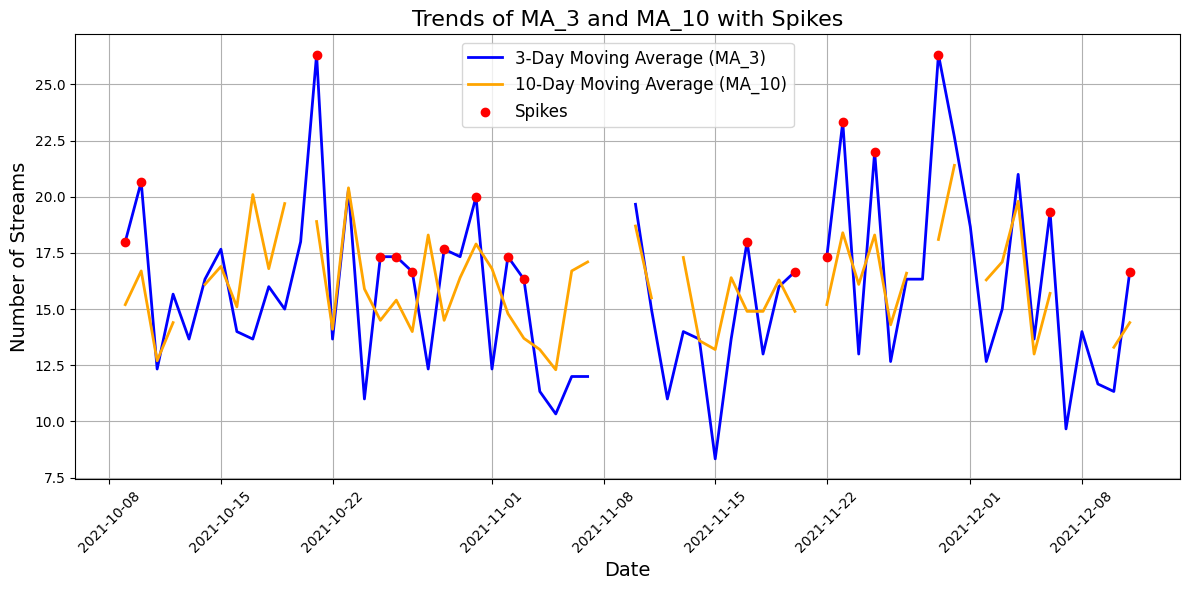

In [12]:
import matplotlib.pyplot as plt

# ensures 'date' is in datetime format for proper sorting and plotting
spikes['date'] = pd.to_datetime(spikes['date'])

# filter for a specific group (replace with desired values in  dataset)
group_filter = (
    (spikes['country'] == 'US') &
    (spikes['region'] == '518') &
    (spikes['gender'] == 'male')

)
group_data = spikes[group_filter]

# sort by date to ensure the plot lines connect in order
group_data = group_data.sort_values('date')

# plotting
plt.figure(figsize=(12, 6))

plt.plot(group_data['date'], group_data['MA_3'], label='3-Day Moving Average (MA_3)', color='blue', linewidth=2)
plt.plot(group_data['date'], group_data['MA_10'], label='10-Day Moving Average (MA_10)', color='orange', linewidth=2)

# Highlight spikes
spike_data = group_data[group_data['spike']]

plt.scatter(spike_data['date'], spike_data['MA_3'], color='red', label='Spikes', zorder=5)

# Add labels, title, and legend
plt.title('Trends of MA_3 and MA_10 with Spikes', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Streams', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


######  